In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits
from scipy.stats import bernoulli
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

Each positive example has the probability $e(x)$ of being selected to be labeled.

And $e(x) = \mathbb{P}(s=1 \vert y=1,x)$. 

So we get that : $f_l = \frac{e(x)}{c}f_+(x)$, which is a biased version of the positive density. c is the normalization constant, the $\textit{label frequency}$, defined by $c=\mathbb{P}(s=1 \vert y=1)$.

Class prior : $\alpha = \mathbb{P}(y=1)$

$c=\mathbb{P}(s=1 \vert y=1)=\frac{\mathbb{P}(s=1,y=1)}{\mathbb{P}(y=1)} = \frac{\mathbb{P}(s=1)}{\mathbb{P}(y=1)} \text{(by definition of PU)}$

So in single training set scenario : $c=\frac{\mathbb{P}(s=1)}{\alpha}$


### So, first assumption : SCAR 
$e(x)=c$

### Very common other assuption, SAR (selected at random)

The probability of being labelled depends on attributes of a datapoint.

Def : The labeled sample is a biased sample from the original distribution, and the bias only depends on the attributes and is defined by the propensity score $e(x)$, we have : $e(x) = \mathbb{P}(s=1 \vert x,y=1)$

### Probabilistic gap : examples that resamble the negative ones are less likely to be labeled.

Hence, the probability gap is defined by : $\Delta \mathbb{P} = \mathbb{P}(y=1 \vert x) - \mathbb{P}(y=0 \vert x)$.

$\rightarrow e(x) = f(\Delta \mathbb{P}(x)), \frac{\partial}{\partial t}f(t) >0$


### Assumption of separability is used in graph frameworks so might be good for material science. 



## Assumptions for an identifiable class prior $\alpha$

Separable classes, non overlapping distributions

Positive subdomain, anchor

Positive function separability

Irreducibility






In [2]:
#digits = load_digits(as_frame = True).data

In [3]:
mushroom_data_df = pd.read_csv('mushroom.csv', encoding = 'utf-8', engine = 'python')

In [4]:
true_mushroom_data = mushroom_data_df
for_class=mushroom_data_df['class']
mushroom_data_df = mushroom_data_df.drop(['class'],axis=1)-mushroom_data_df.drop(['class'],axis=1).mean()/mushroom_data_df.drop(['class',],axis=1).std()




In [5]:
mushroom_data_df['class'] = for_class
mushroom_data_df['label'] = mushroom_data_df['class']

In [6]:
columns_to_use = mushroom_data_df.columns

In [7]:
mushroom_data = mushroom_data_df.to_numpy()

In [8]:
for i in range(mushroom_data.shape[0]):
    random = bernoulli.rvs(p=1/2)
    if mushroom_data[i,8] == 0:
        mushroom_data[i,8] = 99
    elif mushroom_data[i,8] == 1 and random == 1:
        mushroom_data[i,8] = 99
    elif mushroom_data[i,8] == 1 and random == 0:
        mushroom_data[i,8] = 1

# First method : two-step method with k-means and iterative Linear-SVM

In [9]:
mushroom_data_kmeans = mushroom_data

In [10]:
def generalized_euclidian_dist_sq(x,y):
    """a function to calculate euclidian distance for any dimension

    Parameters
    ---------------------
    x,y : array-like
    the two vectors between which we want to calculate the euclidian distance
    --------------------
    """
    dimension = x.shape[0]
    sum_of_squares = 0
    for i in range(dimension):
        sum_of_squares += (x[i]-y[i])**2
    return sum_of_squares

In [11]:
mushroom_data_kmeans.shape

(54035, 10)

In [12]:
mushroom_data_kmeans[1,:8]

array([ 1.45942378e+03,  1.48435640e-01,  1.03892854e+00,  7.70971882e+00,
        2.64134324e+00,  1.55565600e+03,  8.41941702e+00, -1.31150916e+00])

In [13]:
iterations = 100
k = 4

In [14]:
centroids = np.random.uniform(low=0., high=3000, size=(k,8))

In [15]:
mushroom_data_df.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class,label
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,565.680980,2.148750,1.180985,5.039227,-0.407014,1049.737302,5.837479,-2.163619,0.549181,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580,0.497580
min,-1.576223,-1.851564,-0.961071,-2.290281,-1.165698,-1.343997,-2.580583,-3.088410,0.000000,0.000000
25%,287.423777,0.148436,-0.961071,2.709719,-0.895127,419.656003,3.419417,-2.227332,0.000000,0.000000
50%,523.423777,3.148436,0.038929,5.709719,-0.572828,921.656003,8.419417,-2.172587,1.000000,1.000000
75%,779.423777,4.148436,3.038929,7.709719,-0.111266,1521.656003,8.419417,-2.172587,1.000000,1.000000
max,1889.423777,4.148436,5.038929,8.709719,2.669196,3567.656003,9.419417,-1.311509,1.000000,1.000000


In [16]:
list_of_max = mushroom_data_df.describe().loc['max']
list_of_max.pop('label')
list_of_max.pop('class')

1.0

In [17]:
centroids = np.empty((k,8))
position = 0
for i in list_of_max:
    component = np.random.uniform(low=0., high = i , size=k)
    centroids[:,np.where(list_of_max == i)[0][0]] = component
    position += 1


In [18]:
mushroom_data_df_algo = mushroom_data_df.drop(['label', 'class'], axis=1)

In [19]:
mushroom_data_kmeans_train = mushroom_data_kmeans[:,:8]

In [20]:
distances = np.empty((mushroom_data_kmeans_train.shape[0], k))
cluster_cat = np.empty((mushroom_data_kmeans_train.shape[0],1))

In [21]:
n=0
while n<=iterations:
    #computation of weights
    for cluster in range(k):
        for i in range(mushroom_data_kmeans_train.shape[0]):
            distances[i,cluster] = generalized_euclidian_dist_sq(x=mushroom_data_kmeans_train[i,:],
                                                                 y=centroids[cluster,:])
    #defining to which centroid each point is the closest
    for i in range((mushroom_data_kmeans_train.shape[0])):
        cluster_cat[i,0] = np.where(distances[i,:] == np.min(distances[i,:]))[0][0]
    mushroom_data_df_algo['cluster'] = cluster_cat
    centroids = mushroom_data_df_algo.groupby('cluster').mean().to_numpy()
    n += 1

In [22]:
distances_inter_clusters = np.empty((4,4))

for i in range(4):
    for j in range(4):
        distances_inter_clusters[i,j] = generalized_euclidian_dist_sq(x=centroids[i,:],
                                                                      y=centroids[j,:])



In [23]:
distances_inter_clusters_df = pd.DataFrame(distances_inter_clusters)

In [24]:
distances_inter_clusters_df

,0,1,2,3
0,0.000000e+00,4.993770e+05,2.147180e+06,1.063587e+06
1,4.993770e+05,0.000000e+00,5.758150e+05,2.995154e+06
2,2.147180e+06,5.758150e+05,0.000000e+00,6.171473e+06
3,1.063587e+06,2.995154e+06,6.171473e+06,0.000000e+00


In [25]:
mushroom_data_df_kmeans = mushroom_data_df

In [26]:
mushroom_data_df_kmeans['cluster'] = mushroom_data_df_algo['cluster']

In [27]:
mean_per_cluster = mushroom_data_df_kmeans[['class','cluster']].groupby('cluster').mean().to_numpy()

In [28]:
mean_per_cluster

array([[0.41116707],
       [0.49086845],
       [0.68557752],
       [0.48402778]])

In [29]:
positive_cluster = np.where(mean_per_cluster == np.max(mean_per_cluster))[0][0]

In [30]:
positive_cluster

2

In [31]:
f'we now know that the cluster that has the most probable true positive points is cluster {positive_cluster}'

'we now know that the cluster that has the most probable true positive points is cluster 2'

In [32]:
true_negatives = np.where(distances_inter_clusters_df.to_numpy()[:,positive_cluster] == np.max(distances_inter_clusters_df.to_numpy()[:,3]))[0][0]

In [33]:
true_negatives

3

In [34]:
mushroom_data_iterative_svm = pd.DataFrame(mushroom_data_kmeans)
mushroom_data_iterative_svm.columns = columns_to_use
mushroom_data_iterative_svm['cluster'] = mushroom_data_df_algo['cluster']


In [35]:
mushroom_data_iterative_svm['class'] = np.zeros((mushroom_data_iterative_svm.shape[0]))
for i in range(mushroom_data_iterative_svm.shape[0]):
    if mushroom_data_df_kmeans.loc[i,'cluster'] == true_negatives :
        mushroom_data_iterative_svm.loc[i,'class'] = 0
    elif mushroom_data_iterative_svm.loc[i,'cluster'] == positive_cluster:
        mushroom_data_iterative_svm.loc[i,'class'] = 1
    elif mushroom_data_iterative_svm.loc[i,'label'] == 0:
        mushroom_data_iterative_svm.loc[i,'class'] = 99

In [36]:
X_train = mushroom_data_iterative_svm[mushroom_data_iterative_svm["class"].isin([1,0])].drop(['label','cluster','class'],axis = 1).to_numpy()
y_train = mushroom_data_iterative_svm[mushroom_data_iterative_svm["class"].isin([1,0])]['class'].to_numpy()


#class_23 = titanic[titanic["Pclass"].isin([2, 3])]

In [37]:
mushroom_data_iterative_svm.groupby('class').describe()

cap-diameter                                                  \
             count        mean         std         min         25%   
class                                                                
0.0        18182.0  821.349142  327.724063  158.423777  599.423777   
1.0        21099.0  244.824507  136.282968   -1.576223  120.423777   
99.0       14754.0  709.451633  258.805979  170.423777  529.423777   

                                           cap-shape            ... label  \
              50%         75%          max     count      mean  ...   75%   
class                                                           ...         
0.0    756.423777  998.423777  1889.423777   18182.0  2.460668  ...   1.0   
1.0    252.423777  339.423777   699.423777   21099.0  1.461341  ...   1.0   
99.0   675.423777  854.423777  1802.423777   14754.0  2.747392  ...   0.0   

            cluster                                               
       max    count      mean       std  min  25%  50%  75%  max  
class                                                             
0.0    1.0  18182.0  1.373171  1.178316  0.0  0.0  1.0  3.0  3.0  
1.0    1.0  21099.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0  
99.0   0.0  14754.0  0.540396  0.498382  0.0  0.0  1.0  1.0  1.0  

[3 rows x 80 columns]

In [38]:
first_svc = LinearSVC().fit(X=X_train,y=y_train)

In [39]:
true_mushroom_data

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1
54031,82,2,3,2,1.186164,490,12,0.943195,1
54032,82,5,3,2,0.915593,584,12,0.888450,1
54033,79,2,3,2,1.034963,491,12,0.888450,1


In [40]:
prediction_1 = first_svc.predict(mushroom_data_df.drop(['class','label', 'cluster'], axis=1).to_numpy()) 

In [41]:
well_classified = 0
error = 0
for i in range(mushroom_data_df.shape[0]):
    if mushroom_data_df.loc[i,'label'] == prediction_1[i]:
        well_classified+=1
    else:
        error+=1
print('the accurate predictions represent :', (well_classified*100)/mushroom_data_df.shape[0], '\n',
      'the error rate is :', (error*100)/mushroom_data_df.shape[0])

the accurate predictions represent : 60.15360414546127 
 the error rate is : 39.84639585453873


There is still a certain imprecision, but now let's try to implement the iterative aspect of the two step technique with the svm.

In [42]:
iterations_svm = 100

In [43]:
count_svm = 0
X_svm = X_train
y_svm = y_train
while count_svm<=iterations_svm:
    count_svm+=1
    svm = LinearSVC().fit(X=X_svm,y=y_svm)
    predictions_svm = svm.predict(mushroom_data_df.drop(['class','label', 'cluster'], axis=1).to_numpy())
    for i in range(mushroom_data_iterative_svm.shape[0]):
        if predictions_svm[i] == 0:
            mushroom_data_iterative_svm.loc[i,'class'] = 0
        elif predictions_svm[i] == 1:
            mushroom_data_iterative_svm.loc[i,'class'] = 1
    X_svm = mushroom_data_iterative_svm[mushroom_data_iterative_svm["class"].isin([1,0])].drop(['label','cluster','class'],axis = 1).to_numpy()
    y_svm = mushroom_data_iterative_svm[mushroom_data_iterative_svm["class"].isin([1,0])]['class'].to_numpy()






In [44]:
well_classified_svm_final = 0
error_svm_final = 0
for i in range(mushroom_data_df.shape[0]):
    if mushroom_data_df.loc[i,'label'] == predictions_svm[i]:
        well_classified_svm_final+=1
    else:
        error_svm_final+=1
print('the accurate predictions represent :', (well_classified_svm_final*100)/mushroom_data_df.shape[0], '\n',
      'the error rate is :', (error_svm_final*100)/mushroom_data_df.shape[0])

the accurate predictions represent : 58.917368372351255 
 the error rate is : 41.082631627648745


It's problematic that it worsens with the number of iterations.

Maybe try another clustering technique and better adaptation of the predictions because this is very strange (i probably made a mistake somewhere).

### Implementation with scikit-learn

In [45]:
mushroom_sklearn = true_mushroom_data.drop(['class'], axis=1).to_numpy()

In [46]:
clusters_sklearn = KMeans(n_clusters=3, init='random', max_iter=200).fit(X=mushroom_sklearn)

For the elbow method

In [47]:
list_of_inertia = []
for i in range(1,7):
    list_of_inertia.append(KMeans(n_clusters=i, init='random', max_iter=200).fit(X=mushroom_sklearn).inertia_)

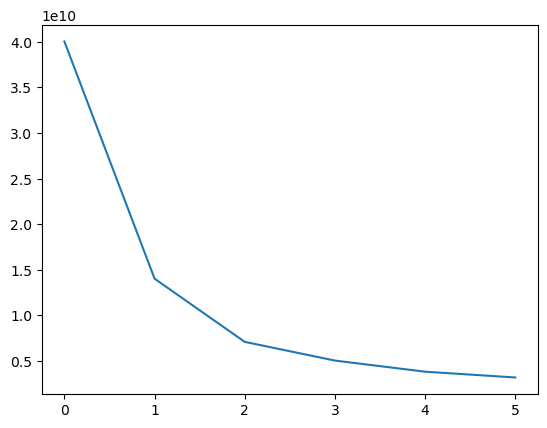

In [48]:
plt.plot(list_of_inertia)

Even if it is not the most optimal, let's stick with 3 clusters so we can take the one that is the further.

In [49]:
clusters_sklearn.labels_

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [50]:
data_clustered = true_mushroom_data

In [51]:
data_clustered['cluster'] = clusters_sklearn.labels_

In [52]:
true_positive_sklearn = np.where(data_clustered[['class','cluster']].groupby(['cluster']).sum().to_numpy()==np.max(data_clustered[['class','cluster']].groupby(['cluster']).sum().to_numpy()))[0][0]



In [53]:
data_clustered[['class','cluster']].groupby(['cluster']).mean()

,class
cluster,
0,0.658727
1,0.416212
2,0.461996


In [54]:
true_positive_sklearn

0

In [55]:
distances_sklearn = np.zeros((3))
for i in range(2):
    distances_sklearn[i] = generalized_euclidian_dist_sq(x=clusters_sklearn.cluster_centers_[1,:],
                                                         y=clusters_sklearn.cluster_centers_[i,:])                 

In [56]:
furthest_cluster = np.where(distances_sklearn == np.max(distances_sklearn))[0][0]

In [57]:
furthest_cluster

0

In [58]:
data_clustered

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class,cluster
0,1372,2,2,10,3.807467,1545,11,1.804273,1,2
1,1461,2,2,10,3.807467,1557,11,1.804273,1,2
2,1371,2,2,10,3.612496,1566,11,1.804273,1,2
3,1261,6,2,10,3.787572,1566,11,1.804273,1,2
4,1305,6,2,10,3.711971,1464,11,0.943195,1,2
...,...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1,0
54031,82,2,3,2,1.186164,490,12,0.943195,1,0
54032,82,5,3,2,0.915593,584,12,0.888450,1,0
54033,79,2,3,2,1.034963,491,12,0.888450,1,0


In [59]:
data_clustered['label'] = data_clustered['class']
for i in range(data_clustered.shape[0]):
    random = bernoulli.rvs(p=3/4)
    if data_clustered.loc[i,'class'] == 1 and random == 0:
        data_clustered.loc[i,'label'] = 1
    elif data_clustered.loc[i,'cluster'] == furthest_cluster:
        data_clustered.loc[i,'label'] = 0
    else:
        data_clustered.loc[i,'label'] = 99

In [60]:
data_clustered['label'].value_counts()

label
99    25134
0     21496
1      7405
Name: count, dtype: int64

In [61]:
test = SVC().fit(X=np.array(data_clustered[data_clustered["label"].isin([1,0])].drop(['class','cluster','label'],axis=1)),
          y=np.array(data_clustered[data_clustered["label"].isin([1,0])]['label']))

X_train, X_test, y_train, y_test = train_test_split(
    data_clustered[data_clustered["label"].isin([1,0])].drop(['class','cluster','label'],axis=1),
    data_clustered[data_clustered["label"].isin([1,0])]['label'], test_size=0.2)

In [74]:
#first try, we only update the negatives
iterations_sklearn = 50
count_sklearn = 0
X_ls_svm = np.array(data_clustered[data_clustered["label"].isin([1,0])].drop(['class','cluster','label'],axis=1))
y_ls_svm = np.array(data_clustered[data_clustered["label"].isin([1,0])]['label'])
while count_sklearn<=iterations_sklearn:
    count_sklearn+=1
    svm_sklearn = SVC().fit(X=X_ls_svm, y=y_ls_svm)
    y_ls_svm = svm_sklearn.predict(data_clustered.drop(['class', 'cluster', 'label'], axis=1).to_numpy())
    X_ls_svm = np.array(data_clustered.drop(['class', 'label', 'cluster'], axis=1))
    good_label_it_svm = 0
    wrong_label_it_svm = 0
#problem because at some point we only consider the same dataset again and again so no change in the predictions. Probably
#have to correct it with bias and adaptative weights.

the percentage rate of correct labelled points is : 40.74396224669196 
 the percentage rate of wrongly labelled points is : 59.25603775330804
the percentage rate of correct labelled points is : 40.73285833256223 
 the percentage rate of wrongly labelled points is : 59.26714166743777
the percentage rate of correct labelled points is : 40.73100768020727 
 the percentage rate of wrongly labelled points is : 59.26899231979273
the percentage rate of correct labelled points is : 40.73100768020727 
 the percentage rate of wrongly labelled points is : 59.26899231979273
the percentage rate of correct labelled points is : 40.73100768020727 
 the percentage rate of wrongly labelled points is : 59.26899231979273
the percentage rate of correct labelled points is : 40.73100768020727 
 the percentage rate of wrongly labelled points is : 59.26899231979273
the percentage rate of correct labelled points is : 40.73100768020727 
 the percentage rate of wrongly labelled points is : 59.26899231979273
the pe

KeyboardInterrupt: 

In [ ]:
good_label_it_svm = 0
wrong_label_it_svm = 0
for i in range(data_clustered.shape[0]):
    if data_clustered.loc[i,'class'] == y_ls_svm[i]:
        good_label_it_svm += 1
    else:
        wrong_label_it_svm += 1
print('the percentage rate of correct labelled points is :', (good_label_it_svm*100)/data_clustered.shape[0], '\n',
      'the percentage rate of wrongly labelled points is :', (wrong_label_it_svm*100)/data_clustered.shape[0])
    

In [ ]:
data_clustered.shape

In [ ]:
np.array(data_clustered[data_clustered["label"].isin([1,0])]['label']).sum()

In [ ]:
np.array(data_clustered['class']).sum()

In [64]:
data_clustered

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class,cluster,label
0,1372,2,2,10,3.807467,1545,11,1.804273,1,2,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1,2,99
2,1371,2,2,10,3.612496,1566,11,1.804273,1,2,99
3,1261,6,2,10,3.787572,1566,11,1.804273,1,2,99
4,1305,6,2,10,3.711971,1464,11,0.943195,1,2,99
...,...,...,...,...,...,...,...,...,...,...,...
54030,73,5,3,2,0.887740,569,12,0.943195,1,0,0
54031,82,2,3,2,1.186164,490,12,0.943195,1,0,0
54032,82,5,3,2,0.915593,584,12,0.888450,1,0,0
54033,79,2,3,2,1.034963,491,12,0.888450,1,0,0
